In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
train_data = pd.read_pickle('/content/drive/MyDrive/choosen/train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/choosen/test.pkl')

In [25]:
metadata = pd.read_csv('/content/drive/MyDrive/choosen/ISIC_2019_Training_Metadata.csv')
metadata.drop(columns='lesion_id', inplace=True)

In [26]:
metadata['sex'] = metadata['sex'].map({'male': 1, 'female': 0})
# Define a mapping dictionary for the unique values
anatom_mapping = {
    'lower extremity': 0,
    'posterior torso': 1,
    'upper extremity': 2,
    'anterior torso': 3,
    'head/neck': 4,
    'palms/soles': 5,
    'lateral torso': 6,
    'oral/genital': 7
}

# Apply the mapping to the column
metadata['anatom_site_general'] = metadata['anatom_site_general'].map(anatom_mapping)

In [27]:
common_images = set(train_data['image']).intersection(metadata['image'])
train_metadata = metadata[metadata['image'].isin(common_images)]

common_images = set(test_data['image']).intersection(metadata['image'])
test_metadata = metadata[metadata['image'].isin(common_images)]

In [28]:
labels_one_hot = train_data.iloc[:, 1:].values
labelstrain = [list(row).index(1.0) for row in labels_one_hot]
labels_one_hot = test_data.iloc[:, 1:].values
labelstest = [list(row).index(1.0) for row in labels_one_hot]

In [33]:
train_metadata['sex'] = train_metadata['sex'].apply(
    lambda x: np.random.choice([0, 1]) if np.isnan(x) else x)

test_metadata['sex'] = test_metadata['sex'].apply(
    lambda x: np.random.choice([0, 1]) if np.isnan(x) else x)

<ipython-input-33-bda2595aaac5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['sex'] = train_metadata['sex'].apply(
<ipython-input-33-bda2595aaac5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_metadata['sex'] = test_metadata['sex'].apply(


In [37]:
most_frequent_site = train_metadata['anatom_site_general'].mode()[0]  # Get the mode
train_metadata['anatom_site_general'].fillna(most_frequent_site, inplace=True)
test_metadata['anatom_site_general'].fillna(most_frequent_site, inplace=True)

<ipython-input-37-3c4723b7d771>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_metadata['anatom_site_general'].fillna(most_frequent_site, inplace=True)
<ipython-input-37-3c4723b7d771>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['anatom_site_general'].fillna(most_frequent_site, inplace=True)
<ipython-input-37-3c4723b

In [45]:
median_age = train_metadata['age_approx'].median()
train_metadata['age_approx'].fillna(median_age, inplace=True)
test_metadata['age_approx'].fillna(median_age, inplace=True)

<ipython-input-45-4c741672dea3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['age_approx'].fillna(median_age, inplace=True)
<ipython-input-45-4c741672dea3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_metadata['age_approx'].fillna(median_age, inplace=True)
<ipython-input-45-4c741672dea3>:3: SettingWithCopyWarning: 


In [46]:
train_metadata.head()

,image,age_approx,anatom_site_general,sex
10,ISIC_0000011,35.0,0.0,0.0
33,ISIC_0000035_downsampled,25.0,0.0,0.0
63,ISIC_0000065_downsampled,30.0,1.0,0.0
118,ISIC_0000126_downsampled,60.0,4.0,0.0
145,ISIC_0000154_downsampled,60.0,4.0,1.0


In [47]:
train_metadata.reset_index(drop=True, inplace=True)
test_metadata.reset_index(drop=True, inplace=True)

In [48]:
train_metadata.head()

,image,age_approx,anatom_site_general,sex
0,ISIC_0000011,35.0,0.0,0.0
1,ISIC_0000035_downsampled,25.0,0.0,0.0
2,ISIC_0000065_downsampled,30.0,1.0,0.0
3,ISIC_0000126_downsampled,60.0,4.0,0.0
4,ISIC_0000154_downsampled,60.0,4.0,1.0


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assume that train_metadata and labelstrain are already loaded and preprocessed

# Extract features (excluding the 'image' column and any target column)
X_train = train_metadata.drop(columns=['image'])  # Remove 'image' column if not used for training
y_train = np.array(labelstrain)  # Assuming this is a list or array of labels

X_test = test_metadata.drop(columns=['image'])  # Remove 'image' column if not used for training
y_test = np.array(labelstest)  # Assuming this is a list or array of labels

# Normalize/Standardize the data (especially for age and anatomical site)
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_scaled_test = scaler.fit_transform(X_test)

# Convert to torch tensors
X_train = torch.tensor(X_scaled_train, dtype=torch.float32)
X_val = torch.tensor(X_scaled_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Use 'long' for classification labels
y_val = torch.tensor(y_test, dtype=torch.long)  # Use 'long' for classification labels

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define the fully connected model
class FCModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCModel, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        self.fc3 = nn.Linear(64, output_dim)  # Output layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # For multi-class classification

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)  # For classification output

# Initialize the model, define loss and optimizer
input_dim = X_scaled.shape[1]  # Number of features
output_dim = len(np.unique(y))  # Number of unique classes (assuming it's a classification task)
model = FCModel(input_dim, output_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 1000
# Training function
trainingHolder = []
testingHolder = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = (correct_preds / total_preds) * 100

    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    trainingHolder.append(accuracy)


    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = (correct_preds / total_preds) * 100
    # print(f"Validation Accuracy: {accuracy:.2f}%")
    testingHolder.append(accuracy)

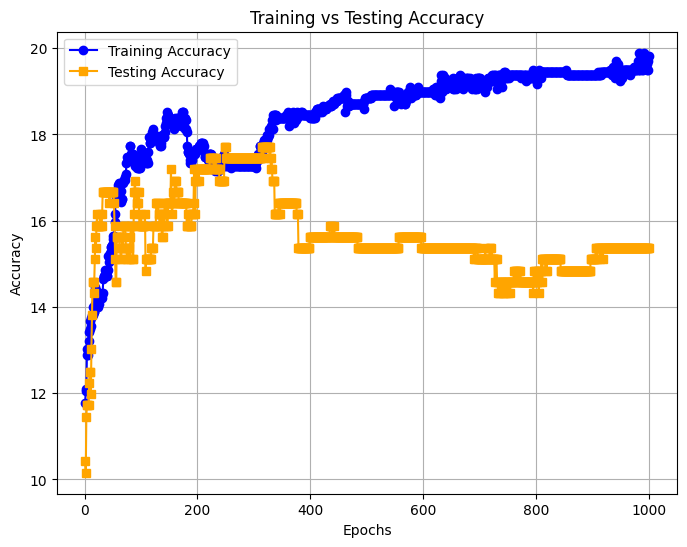

In [67]:
epochs = range(1, len(trainingHolder) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, trainingHolder, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, testingHolder, label='Testing Accuracy', marker='s', color='orange')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [68]:
max(testingHolder)

17.708333333333336

In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# Split data into training and testing sets (80% train, 20% test)

# -----------------
# 2. Random Forest Model
# -----------------

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# Detailed classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# -------------------
# 3. Logistic Regression Model
# -------------------

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg_model.predict(X_test)

# Evaluate the Logistic Regression model
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print(f"Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%")

# Detailed classification report for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))


Random Forest Accuracy: 10.94%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.23      0.14        48
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        48
           7       0.13      0.65      0.21        48

    accuracy                           0.11       384
   macro avg       0.03      0.11      0.04       384
weighted avg       0.03      0.11      0.04       384

Logistic Regression Accuracy: 12.24%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        48
           2       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z